<a href="https://colab.research.google.com/github/Marlianur09/Tugas_Praktikum_023_043/blob/main/Modul_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
train = pd.read_csv('aptos2019-blindness-detection/train.csv')
test = pd.read_csv('aptos2019-blindness-detection/test.csv')
submission= pd.read_csv('aptos2019-blindness-detection/sample_submission.csv')
train_dir = 'aptos2019-blindness-detection/train_images'


In [3]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
!pip install opencv-python

In [ ]:
!pip install seaborn

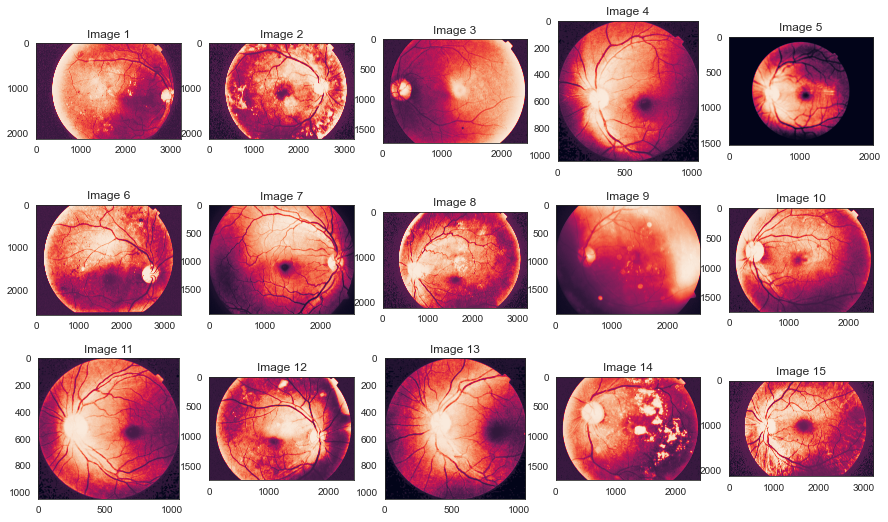

In [4]:
import seaborn as sns
import cv2
sns.set_style("white")
count = 1
plt.figure(figsize=[15, 15])
for img_name in train['id_code'][:15]:
    img = cv2.imread("aptos2019-blindness-detection/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0,
	  tileGridSize=(8, 8))
    equalized = cv2.equalizeHist(img)
    plt.subplot(5, 5, count)
    plt.imshow(equalized)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

In [5]:
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [6]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",
    target_size=(224, 224),
    subset='training',
    color_mode='rgb')

Found 2930 validated image filenames belonging to 5 classes.


In [7]:
valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",    
    target_size=(224, 224),
    subset='validation',
    color_mode='rgb')

Found 732 validated image filenames belonging to 5 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        target_size=(224, 224),
        batch_size=16,
        shuffle=False,
        class_mode=None)

Found 1928 validated image filenames.


In [9]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
!rm -rf ./logs/ 

In [10]:
xvl, yvl = zip(*(valid_generator[i] for i in range(len(valid_generator))))
x_val, y_val = np.vstack(xvl), np.vstack(yvl)

In [11]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import InputLayer, Activation, Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=20, padding='same'))
model.add(Conv2D(filters=32, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=5, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=3, padding='same'))
model.add(Conv2D(filters=128, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, strides=3, padding='same', activation='relu')) 

model.add(Flatten())

  # Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
  
model.compile(optimizer=Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['acc'])
 



C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
his=model.fit(train_generator, 
          validation_data=valid_generator, 
          epochs=20,
          )


Epoch 1/100
184/184 [==============================] - 781s 4s/step - loss: 1.2883 - acc: 0.4959 - val_loss: 1.1233 - val_acc: 0.4604
Epoch 2/100
184/184 [==============================] - 962s 5s/step - loss: 0.9320 - acc: 0.6747 - val_loss: 0.8966 - val_acc: 0.6885
Epoch 3/100
184/184 [==============================] - 967s 5s/step - loss: 0.8344 - acc: 0.7133 - val_loss: 0.8663 - val_acc: 0.6981
Epoch 4/100
184/184 [==============================] - 910s 5s/step - loss: 0.8178 - acc: 0.7174 - val_loss: 0.8229 - val_acc: 0.6967
Epoch 5/100
184/184 [==============================] - 884s 5s/step - loss: 0.8156 - acc: 0.7160 - val_loss: 0.8195 - val_acc: 0.7036
Epoch 6/100
184/184 [==============================] - 351s 2s/step - loss: 0.8163 - acc: 0.7188 - val_loss: 0.8207 - val_acc: 0.7008
Epoch 7/100
184/184 [==============================] - 401s 2s/step - loss: 0.8212 - acc: 0.7174 - val_loss: 0.8229 - val_acc: 0.7049
Epoch 8/100
184/184 [==============================] - 914s 5s

In [ ]:
model.save('model/Moduul3/modelCNNHyper.h5')

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    448       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 16)   0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    4640      
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 average_pooling2d (AverageP  (None, None, None, 32)   0         
 ooling2D)                                              

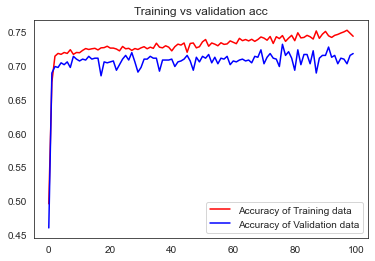

<Figure size 432x288 with 0 Axes>

In [ ]:
get_acc = his.history['acc']
value_acc = his.history['val_acc']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation acc')
plt.legend(loc=0)
plt.figure()
plt.show()


In [ ]:
plt.savefig("model/Moduul3/modelCNNHyperacc.svg")

<Figure size 432x288 with 0 Axes>

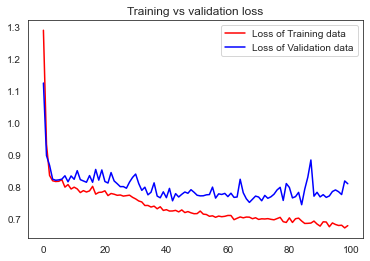

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()


In [ ]:
plt.savefig("model/Moduul3/modelCNNHyperloss.svg")

<Figure size 432x288 with 0 Axes>

In [12]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [13]:
base_model = tf.keras.applications.ResNet152V2(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [14]:
# Freezing Layers

for layer in base_model.layers[:-10]:
    layer.trainable=False

In [15]:
# Building Model

model2=Sequential()
model2.add(base_model)
model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(BatchNormalization())
model2.add(Dense(256,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(128,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(32,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dense(5,activation='softmax'))

In [16]:

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 256)               25690368  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                      

In [17]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [18]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [19]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 2,verbose = 1,factor = 0.8, min_lr = 1e-6)

mcp = ModelCheckpoint('ResNet152V2.h5')

es = EarlyStopping(verbose=1, patience=2)

In [20]:
model2.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=METRICS)

In [21]:
STEP_SIZE_TRAIN1 = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID1 = valid_generator.n//valid_generator.batch_size

In [22]:
print(STEP_SIZE_TRAIN1)
print(STEP_SIZE_VALID1)

183
45


In [23]:
model2.save('model/Moduul5/modelResnet15(2).h5')

C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [24]:
%time
his2= model2.fit(train_generator ,validation_data=valid_generator ,epochs=10,callbacks=[lrd,mcp,es])

Wall time: 0 ns
Epoch 1/10
184/184 [==============================] - 690s 4s/step - loss: 0.9361 - accuracy: 0.8784 - precision: 0.8066 - recall: 0.5154 - auc: 0.8868 - f1_score: 0.6211 - val_loss: 1.1516 - val_accuracy: 0.8822 - val_precision: 0.7223 - val_recall: 0.6680 - val_auc: 0.8941 - val_f1_score: 0.6935 - lr: 0.0010
Epoch 2/10
184/184 [==============================] - 585s 3s/step - loss: 0.7854 - accuracy: 0.8964 - precision: 0.8375 - recall: 0.5980 - auc: 0.9221 - f1_score: 0.6943 - val_loss: 0.7584 - val_accuracy: 0.9022 - val_precision: 0.7931 - val_recall: 0.6913 - val_auc: 0.9339 - val_f1_score: 0.7372 - lr: 0.0010
Epoch 3/10
184/184 [==============================] - 700s 4s/step - loss: 0.7421 - accuracy: 0.9000 - precision: 0.8412 - recall: 0.6164 - auc: 0.9311 - f1_score: 0.7068 - val_loss: 1.0209 - val_accuracy: 0.8902 - val_precision: 0.7398 - val_recall: 0.6954 - val_auc: 0.9110 - val_f1_score: 0.7149 - lr: 0.0010
Epoch 4/10
184/184 [============================

In [25]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train,
        directory = "aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(224, 224),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 3662 validated image filenames.


In [26]:
STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

C:\Users\Asus\AppData\Local\Temp/ipykernel_3904/1421930204.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)


                      count      mean       std       min       25%       50%  \
0 - No DR               5.0  0.000000  0.000000  0.000000  0.000000  0.000000   
1 - Mild                5.0  0.186599  0.079999  0.097297  0.148148  0.169492   
2 - Moderate            5.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3 - Severe              5.0  0.000533  0.000766  0.000000  0.000000  0.000000   
4 - Proliferative DR    5.0  0.812869  0.080526  0.687535  0.792746  0.830508   

                           75%       max  
0 - No DR             0.000000  0.000000  
1 - Mild              0.207254  0.310803  
2 - Moderate          0.000000  0.000000  
3 - Severe            0.001001  0.001662  
4 - Proliferative DR  0.850851  0.902703  


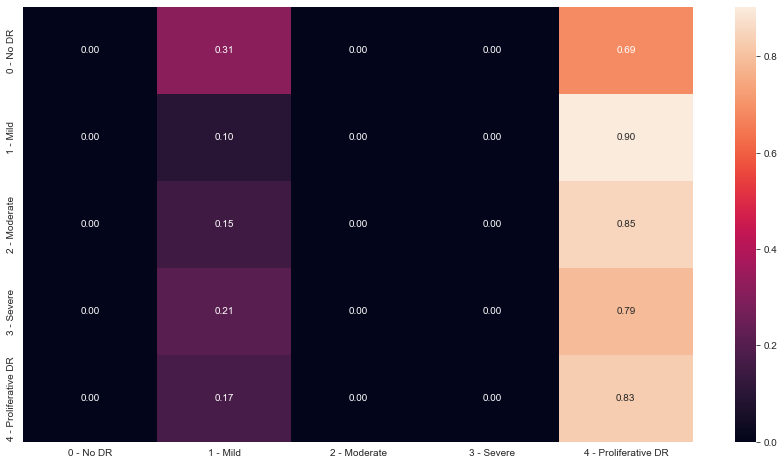

In [27]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
print(df_cm.describe().T)
plt.figure(figsize=(15, 8))
sns.heatmap(df_cm, annot=True, fmt='.2f')
plt.show()

In [28]:
df_cm.head(5)

,0 - No DR,1 - Mild,2 - Moderate,3 - Severe,4 - Proliferative DR
0 - No DR,0.0,0.310803,0.0,0.001662,0.687535
1 - Mild,0.0,0.097297,0.0,0.000000,0.902703
2 - Moderate,0.0,0.148148,0.0,0.001001,0.850851
3 - Severe,0.0,0.207254,0.0,0.000000,0.792746
4 - Proliferative DR,0.0,0.169492,0.0,0.000000,0.830508
